# Assignment 1

In [40]:
import math, random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [42]:
# Load in the training set
X_train = np.load('Assignment1-Dataset/train_data.npy')
y_train = np.load('Assignment1-Dataset/train_label.npy')
# Reshape the label to a 1-d vector
y_train = y_train.reshape(-1,)

# # Load in the test set
X_test = np.load('Assignment1-Dataset/test_data.npy')
y_test = np.load('Assignment1-Dataset/test_label.npy')
# Reshape the label to a 1-d vector
y_test = y_test.reshape(-1,)

# Normalize (optional)
def normalize(X, X2):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    X2 = (X2 - X.mean(axis=0)) / X.std(axis=0) # Normalize the data with the mean and sd from train set
    return X, X2

X_train, X_test = normalize(X_train, X_test)

print("Loaded dataset and normalized")

Loaded dataset and normalized


## Data Exploratory

In [44]:
df = pd.DataFrame(X_train)

print('There are {} rows and {} features.'.format(X_train.shape[0], X_train.shape[1]))
print()
# Check if there is missing value
df_na = df.isna().sum()
print("There is {} missing value.".format(len(df_na[df_na > 0])))
print()

df_ranged = df.max(axis=0) - df.min(axis=0)
print("The largest and smallest range of a feature is {:.2f} and {:.2f}.".format(df_ranged.max(), df_ranged.min()))
print()

# Function to return the upper and lower boundary
# for not being a outlier
def iqr(feature):
    q75, q25 = np.percentile(feature, [75 ,25])
    qr = q75 - q25
    upper = q75 + (1.5 * qr)
    lower = q25 - (1.5 * qr)
    return upper, lower

# Function to detect outlier
def outlier(i, upper, lower):
    if i > upper: return True
    elif i < lower: return True
    else: return False

# Dict to see how many outlier are there (%) in each feature
outlier_count = {}
for i in df.columns:
    up, low = iqr(df[i])
    detection = df[i].apply(lambda x: outlier(x, up, low))
    outlier_count[i] = detection.sum() * 100 / detection.count()


print("Average proportion of outliers is {:.2f}%.".format(np.array(list(outlier_count.values())).mean()))
print("Max proportion of outliers is {:.2f}%.".format(np.array(list(outlier_count.values())).max()))
print("Since the dataset has {} data points, we agree that the outliers won't impose great effect".format(df.shape[0]))

There are 50000 rows and 128 features.

There is 0 missing value.

The largest and smallest range of a feature is 21.29 and 6.59.

Average proportion of outliers is 2.59%.
Max proportion of outliers is 5.42%.
Since the dataset has 50000 data points, we agree that the outliers won't impose great effect


## Coding the Neural Network

In [46]:
# Creating a Dense Layer class
class dense:
    # Initiate the class with required input and output dimension, and regularization
    def __init__(self, input_dim, output_dim, w_regularizer_l1=0, w_regularizer_l2=0, 
b_regularizer_l1=0, b_regularizer_l2=0):
        
        # Initiate the weights and bias
        self.w = 0.01 * np.random.randn(input_dim, output_dim)
        self.b = np.zeros((1, output_dim))
        
        # Initiate the regularizer lambda value
        self.w_regularizer_l1 = w_regularizer_l1
        self.w_regularizer_l2 = w_regularizer_l2
        self.b_regularizer_l1 = b_regularizer_l1
        self.b_regularizer_l2 = b_regularizer_l2
    
    # Forward propagation of the Dense layer
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs when it is pased into the layer
        self.output = inputs.dot(self.w) + self.b # Calculate the output of this later
    
    # Backward propagation of the Dense layer
    def backward(self, dvalues):
        # Get gradient on weights and bias
        # Dot product of input transposed and the gradient from previous layer
        self.d_w = np.dot(self.inputs.T, dvalues)
        self.d_b = np.sum(dvalues, axis=0, keepdims=True) # Sum up the delta from previous layer
        
        # Add the regularization penalties calculated from the original weights if to the gradient of the weights
        if self.w_regularizer_l1 > 0:
            dL1 = np.ones_like(self.w)
            # For negative weights, the derivative of it is -1
            dL1[self.w < 0] = -1
            self.d_w += self.w_regularizer_l1 * dL1
        
        if self.w_regularizer_l2 > 0:
            self.d_w += 2 * self.w_regularizer_l1 * self.w

        # Add the regularization penalties calculated from the original bias if to the gradient of the weights
        if self.b_regularizer_l1 > 0:
            dL1 = np.ones_like(self.b)
            # For negative bias, the derivative of it is -1
            dL1[self.b < 0] = -1
            self.d_w += self.b_regularizer_l1 * dL1
        
        if self.b_regularizer_l2 > 0:
            self.d_b += self.b_regularizer_l2 * self.b
            
        # Gradient wrt inputs to be backprogated to the next layer
        self.dinputs = np.dot(dvalues, self.w.T)
    
# Create the ReLu activaton layer class
class ReLu:
    
    # Forward propagation for ReLu
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs passed into this later
        self.output = np.maximum(0, inputs) # Apply the relu function on each inputs
    
    # Back propagation for Relu
    def backward(self, dvalues):
        # Use the copy of the gradient instead on changing them
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <0] = 0 # Apply the derivative of ReLu to the gradient wrt to gradient from last layer

# Create the tanh activaton layer class
class tanh:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.tanh(self.inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs = 1.0-(self.dinputs**2)

# Create the Softmax layer class
class softmax:
    # Forward propagation for Softmax
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs passed into this layer
        
        # Apply the softmax function to the input
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        # Save the output values (predicted probabilities of each class) in this layer
        self.output = prob
    
    # Back propagation for Softmax
    def backward(self, dvalues):
        # Create an empty array with shape (n_class,)
        self.inputs = np.empty_like(dvalues)
        
        # Calculating the gradient of Softmax layer using its derivative
        for idx, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacob_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
        self.dinputs[idx] = np.dot(jacob_matrix, single_dvalue)
    
# Create a general Loss class for different loss function
class Loss:
    
    # Add l1, l2, loss to a lump sum regularization loss
    def regularization_loss(self, layer):
        regularization_loss = 0
        # Add l1 loss of weights to regularization loss
        if layer.w_regularizer_l1 > 0:
            regularization_loss += layer.w_regularizer_l1 * np.sum(np.abs(layer.w))
        # Add l2 loss of weights to regularization loss
        if layer.w_regularizer_l2 > 0:
            regularization_loss += layer.w_regularizer_l2 * np.sum(np.abs(layer.w * layer.w))
        # Add l1 loss of biasa to regularization loss 
        if layer.b_regularizer_l1 > 0:
            regularization_loss += layer.b_regularizer_l1 * np.sum(np.abs(layer.b))
        # Add l2 loss of biasa to regularization loss
        if layer.b_regularizer_l2 > 0:
            regularization_loss += layer.b_regularizer_l1 * np.sum(np.abs(layer.b * layer.b))
        
        return regularization_loss
    
    # A vanilla way to calculate loss using the loss function without regularization
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
# Create Crossentropy loss class with inherit the generl Loss class
class Loss_CategoricalCrossentropy(Loss):
    
    # Forward propagation of CrossEntropy loss function
    # which takes the output of the softmax layer as y_pred
    def forward(self, y_pred, y):
        sample = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7) # clipped the prediction to avoid divisio by 0
        
        if len(y.shape) == 1:
            # Produce the vector of the predicted probability of the correct label
            correct_confidence = y_pred_clipped[range(sample), y] 
        if len(y.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y, axis=1)
        
        # Calculate the negative log likelihoods
        negative_log_likelihoods = -np.log(correct_confidence)
        return negative_log_likelihoods
    
    # Back propagation of CrossEntropy loss function
    def backward(self, dvalues, y):
        
        # Get the number of predictions (length of y_pred)
        sample = len(dvalues)
        # Get the number of class in the prediction
        labels = len(dvalues[0])
        
        # Create one-hot encoding if y is an index label
        if len(y.shape) == 1:
            y = np.eye(labels)[y]
        
        # Calculate the gradient wrt to input values using the derivative of the crossentropy loss
        self.dinputs = -y / dvalues
        
        # Normalize the gradient according to the batch size
        self.dinputs = self.dinputs / sample

# Create the output layer as a combination of Softmax and CrossEntroly Loss
class softmax_crossentropy_loss():
    
    # Initiate the layer with the chosen activation and loss function
    def __init__(self):
        self.activation = softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward propogation for this layer
    def forward(self, inputs, y, test=False):
            
            # Get predictsion by pass forwad in the Softmax class
            # with the input it received from the previous layer
            self.activation.forward(inputs)
            
            # Save the output values (prediction) in this layer
            self.output = self.activation.output
            
            # If we are doing testing, no more follow up action
            if test == True:
                pass
            # During training, use the chosen loss function to get the loss
            elif test == False:
                return self.loss.calculate(self.output, y)
    
    # Back propagation for this layer
    def backward(self, dvalues, y):
        sample = len(dvalues)
        
        # In case the predicted values are vector
        # Get the index with highest probability
        if len(y) == 2:
            y = np.argmax(y, axis=1)
        
        # Calculate the gradient of from the cross entropy loss
        # dinputs and dvalues here are the output (prediction) from the output layer (softmax)
        self.dinputs = dvalues.copy()
        self.dinputs[range(sample), y] -= 1 # Calculate the gradient of loss and softmax using chain rule
        self.dinputs = self.dinputs / sample # Normalize the gradient

# Create the Optimizer (Stochastic gradient descent) class
class Optimizer_SGD:
    
    # Initiate the class with the learning rate, decay rate and momentum
    def __init__(self, lr=0.1, decay=0., momentum=0.):
        self.lr = lr
        self.current_lr = lr
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Precall the decay function
    # Since interation initiated at 0, the learning rate is still the preset one
    def pre_update(self):
        # Continue update the learning rate with the decay rate after each epochs
        if self.decay:
            self.current_lr = self.lr * (1 / (1 + self.decay * self.iterations))
    
    # Update the weights and bias with the gradient from back propagation
    def update_params(self, layer):
        
        # If there is a momentum, we apply momentun to the updates
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                
                # Momentum at start is 0
                layer.weight_momentums = np.zeros_like(layer.w)
                layer.bias_momentum = np.zeros_like(layer.b)
            
            # The negative update is increased by the momentum
            w_updates = self.momentum * layer.weight_momentums - self.current_lr * layer.d_w
            
            # Update the momentum from the update after each epoch
            layer.weight_momentums = w_updates
            
            # Similar handling for bias
            b_updates = self.momentum * layer.bias_momentum - self.current_lr * layer.d_b
            layer.bias_momentum = b_updates
        
        else:
            # Regular updates by multiplying the gradient with the learning rate
            w_updates = -self.current_lr * layer.d_w
            b_updates = -self.current_lr * layer.d_b
        
        # Update the weights and bias
        layer.w += w_updates
        layer.b += b_updates
        
    def update_BN_param(self, layer):
        
        # If there is a momentum, we apply momentun to the updates
        if self.momentum:
            if not hasattr(layer, 'gamma_momentums'):
                
                # Momentum at start is 0
                layer.gamma_momentums = np.zeros_like(layer.gamma)
                layer.beta_momentum = np.zeros_like(layer.beta)
            
            # The negative update is increased by the momentum
            gamma_updates = self.momentum * layer.gamma_momentums - self.current_lr * layer.d_gamma
            
            # Update the momentum from the update after each epoch
            layer.gamma_momentums = gamma_updates
            
            # Similar handling for bias
            beta_updates = self.momentum * layer.beta_momentum - self.current_lr * layer.d_beta
            layer.beta_momentum = beta_updates
        
        else:
            # Regular updates by multiplying the gradient with the learning rate
            gamma_updates = -self.current_lr * layer.d_gamma
            beta_updates =  -self.current_lr * layer.d_beta
        
        # Update the weights and bias
        layer.gamma += gamma_updates
        layer.beta += beta_updates
    
    # Keep track of the number of epoches
    def post_update(self):
        self.iterations += 1

# Create the Dropout layer
class Dropout:
    # Initiate layer with drop out rate (drop out here is the ratio of units to be disabled)
    def __init__(self, rate):
        self.rate = 1-rate
    
    # Forward propagation for dropout layer
    def forward(self, inputs):
        # Save the inputs in this layer
        self.inputs = inputs
        
        # Create the mask using the bernoulli distribution with rate as the probability
        # Dividing the self.rate keeps the total values of the input the same
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        
        # Disable the randomly selected neurons
        self.output = inputs * self.binary_mask
        
    # Back propagation for Drop out layer
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

# Create the Batch Normalization layer
class Batch_norm:
    
    # Initiate the learnable parameters gamma and beta with default values
    def __init__(self,gamma=0.99, beta=0.):
        self.g = gamma
        self.b = beta
    
    # Forward propagation
    def forward(self, inputs):

        # Save the output from previous layer as inputs
        self.inputs = inputs

        # Get the mean, variance of this batch
        self.x_mean = inputs.mean(axis=0)
        self.x_var = inputs.var(axis=0)

        # Normalize the batch using the equation from the paper
        self.inv_var = 1/ (self.x_var + 1e-7)
        output = (inputs - self.x_mean) * (self.inv_var) ** 0.5

        # Save the output of this layer and to pass it to the next layer
        self.output = output
    
    # Backward propagation
    def backward(self, dvalues):
        
        # Get the number of samples and the dimension of the data
        N, d = dvalues.shape

        # Initiate the learnable parameters
        self.gamma = np.full((N, d), self.g)
        self.beta = np.full((N, d), self.b)
        
        # Assign the normalized values as x_til for simpler code
        x_til = self.output

        # intermediate partial derivatives
        dx_til = dvalues * self.gamma

        # final partial derivatives
        dinputs = (1. / N) * self.inv_var  * (N*dx_til - np.sum(dx_til, axis=0)
            - x_til*np.sum(dx_til*x_til, axis=0))
        dbeta = np.sum(dvalues, axis=0)
        dgamma = np.sum(x_til*dvalues, axis=0)
        
        # return the gradient and pass them to the next layer if suitable
        self.dinputs = dinputs
        self.d_gamma = dgamma
        self.d_beta = dbeta

# Running the network

In [48]:
# #Set some of the paramaters for the training process
# epochs = 50
# batch_size = 128
# learning_rate = 0.005


# # Model
# # Add a Dense layer with input shape = 128 and conected to 64 hidden units, along with regularizer values
# dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
# # Add the Batch normalization layer
# batch_norm1 = Batch_norm()
# # Add a Relu activation layer
# activation1 = ReLu()
# # Add dropoutlayer with 0.1 rate
# dropout1 = Dropout(0.4)
# # Add a second Dense layer with 64 input_shape and output shape 10 to match the number of class 
# dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)


# batch_norm2 = Batch_norm()
# activation2 = ReLu()
# # Add a second Dense layer with 64 input_shape and output shape 10 to match the number of class 
# dense3 = dense(16,10, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
# activation3 = ReLu()

# # Add a softmax layer for the output to get the probability
# loss_activation = softmax_crossentropy_loss()

# # Set the stochastic gradient descent optimizer with learning rate, decaying rate and momentum
# optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=0.9)

# # Apply Mini-batch
# def create_batches(inputs, targets, batchsize=64):

#     # Ensure the input and label has same length
#     assert inputs.shape[0] == targets.shape[0]

#     # Create a list of indices with length of the input samples
#     indices = np.arange(inputs.shape[0])

#     # Random sample the indices
#     np.random.shuffle(indices)

#     # Yield the batches for training
#     for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
#         excerpt = indices[start_idx:start_idx + batchsize]

#         yield inputs[excerpt], targets[excerpt]


# # Create list to save the accuracies and losses during training
# acc_train = []
# loss_train = []

# for epoch in range(epochs):
    
#     # Mini-batch SGD
#     for batch in create_batches(X_train, y_train, batch_size):
#         x_batch, y_batch = batch
        
#         # Forward propagation
#         # Use x_batch as the input
#         # Eacher layer takes the output of the previous layer

#         # Block 1 with (Dense, Relu, Dropout)
#         dense1.forward(x_batch)
#         batch_norm1.forward(dense1.output)
#         activation1.forward(batch_norm1.output)
#         dropout1.forward(activation1.output)
        
#         # Block 2 with (Dense, Relu, Dropout)
#         dense2.forward(dropout1.output)
#         # batch_norm2.forward(dense2.output)
#         # activation2.forward(batch_norm2.output)

#         # # Block 3 with (Dense, Relu, Dropout)
#         # dense3.forward(activation2.output)
#         # activation3.forward(dense3.output)

#         data_loss = loss_activation.forward(dense2.output, y_batch)

#         # Add up the regularization loss
#         regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

#         # Calculate the total loss of this epoch training for visualization later
#         loss = data_loss + regularization_loss

#         # Backpropagation
#         # From the output of the softmax layer
#         # Each layer will use gradient of previous layers and take derivatives of that with the input of this layer
#         # to get the gradient of this layer
#         loss_activation.backward(loss_activation.output, y_batch)

#         # activation3.backward(loss_activation.dinputs)
#         # dense3.backward(loss_activation.dinputs)

#         # activation2.backward(dense3.dinputs)
#         # batch_norm2.backward(loss_activation.dinputs)
#         dense2.backward(loss_activation.dinputs)

#         dropout1.backward(dense2.dinputs)
#         activation1.backward(dropout1.dinputs)
#         batch_norm1.backward(activation1.dinputs)
#         dense1.backward(batch_norm1.dinputs)

#         # Update optimizer paramters
#         optimizer.pre_update()

#         # Update the weights and bias in the dense layers
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)

#         # Update the learnable gamma and beta in batch normalization
#         optimizer.update_BN_param(batch_norm1)

#         # Iteration + 1 for SGD with momentum
#         optimizer.post_update()

#     # Make a forward pass using the training set and calculate the accuracy and loss

#     # Block 1 with (Dense, Relu, Dropout)
#     dense1.forward(X_train)
#     batch_norm1.forward(dense1.output)
#     activation1.forward(batch_norm1.output)
#     dropout1.forward(activation1.output)
    
#     # Block 2 with (Dense, Relu, Dropout)
#     dense2.forward(dropout1.output)
#     # batch_norm2.forward(dense2.output)
#     # activation2.forward(batch_norm2.output)

#     # # Block 3 with (Dense, Relu, Dropout)
#     # dense3.forward(activation2.output)
#     # activation3.forward(dense3.output)

#     val_loss = loss_activation.forward(dense2.output, y_train)

#     prediction = np.argmax(loss_activation.output, axis=1)
#     if len(y_train) == 2:
#         y_train = np.argmax(y_train, axis=1)
#     accuracy = np.mean(y_train==prediction)


#     # Print training accuracy, loss and learning rate every 5 epochs
#     if not epoch % 5 :
#         print("Finished {} epochs...".format(epoch))
#         print(f"acc:{accuracy:.4f} |loss:{val_loss:.4f} | lr: {optimizer.current_lr:.4f}")
    
#     # Save the accuracy and loss for visualization
#     acc_train.append(accuracy)
#     loss_train.append(val_loss)

# print("Done training")


# # Evaluate on the test set
# dense1.forward(X_test)
# batch_norm1.forward(dense1.output)
# activation1.forward(batch_norm1.output)
# dropout1.forward(activation1.output)

# # Block 2 with (Dense, Relu, Dropout)
# dense2.forward(dropout1.output)
# # batch_norm2.forward(dense2.output)
# # activation2.forward(batch_norm2.output)

# # # Block 3 with (Dense, Relu, Dropout)
# # dense3.forward(activation2.output)
# # activation3.forward(dense3.output)

# loss = loss_activation.forward(dense2.output, y_test)
# prediction = np.argmax(loss_activation.output, axis=1)
# if len(y_test) == 2:
#     y_test = np.argmax(y_test, axis=1)
# accuracy = np.mean(y_test==prediction)

# print("Testing accuracy")
# print("-"*50)
# print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

# # Plot the accuracy and loss per epoch to see the training progress
# plt.plot(acc_train)
# plt.title("Training accuracy vs epochs")
# plt.show()

# plt.plot(loss_train)
# plt.title("Loss vs epochs")
# plt.show()

# Helper function


In [50]:
# Apply Mini-batch
def create_batches(inputs, targets, batchsize=64):

    assert inputs.shape[0] == targets.shape[0] # Ensure the input and label has same length
    indices = np.arange(inputs.shape[0]) # Create a list of indices with length of the input samples
    np.random.shuffle(indices) # Random sample the indices

    # Yield the batches for training
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

def confusion_matrix(pred, actual):
    K = len(np.unique(actual))

    result = np.zeros((K,K))

    # Rows are truth Columns are predictions
    for i in range(len(actual)):
        result[actual[i]][pred[i]] += 1

    precision = []
    recall = []

    for i in range(K):
        precision.append(result[i,i] / np.sum(result[i,:]))
        recall.append(result[i,i] / result[i,:].T.sum())
    
    precision = float(np.sum(precision) / len(precision))
    recall = float(np.sum(recall) / len(recall))

    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

In [52]:
# A function to save all the training and testing result for easier retrieval later
def save_info_df(acc_train_df=None, loss_train_df=None, accuracy_test_df=None, loss_test_df=None, test_names=False, new=False):
    
    if test_names == False:
        return False

    accuracy_train = {}
    loss_train = {}
    accuracy_test = {}
    loss_test = {}

    # Fill the dictionary
    for i, j in enumerate(test_name):
        accuracy_train[j] = all_acc[i]
        loss_train[j] = all_loss[i]
        accuracy_test[j] = all_test_acc[i]
        loss_test[j] = all_test_loss[i]

    # If there is no df loaded, we will create a new df
    if new:
        acc_train_df =  pd.DataFrame(accuracy_train)
        loss_train_df =  pd.DataFrame(loss_train)
        accuracy_test_df =  pd.DataFrame(accuracy_test)
        loss_test_df =  pd.DataFrame(loss_test)

    else:
        # Convert the date into pandas df
        add_acc_train_df =  pd.DataFrame(accuracy_train)
        add_loss_train_df =  pd.DataFrame(loss_train)
        add_acc_test_df =  pd.DataFrame(accuracy_test)
        add_loss_test_df =  pd.DataFrame(loss_test)

        acc_train_df = pd.concat([acc_train_df, add_acc_train_df], axis=1)
        loss_train_df = pd.concat([loss_train_df, add_loss_train_df], axis=1)

        accuracy_test_df = pd.concat([accuracy_test_df, add_acc_test_df], axis=1)
        loss_test_df = pd.concat([loss_test_df, add_loss_test_df], axis=1)


    return acc_train_df, loss_train_df, accuracy_test_df, loss_test_df

# Experiment

# 1 FC-Layer with different learning rate

In [54]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    activation1 = ReLu()

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN, Relu, Dropout)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)
            data_loss = loss_activation.forward(activation1.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            # dense2.backward(loss_activation.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(loss_activation.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            # optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu, Dropout)
        dense1.forward(X_train)
        activation1.forward(dense1.output)
        
        train_val_loss = loss_activation.forward(activation1.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        testing_loss = loss_activation.forward(dense1.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.4127 |loss: 1.7421 |test_acc:0.3348 |test_loss: 3.0944, |precision: 0.3348, |recall: 0.3348, |f1-score: 0.3348
Epochs 11/50 => acc:0.4143 |loss: 1.7052 |test_acc:0.3179 |test_loss: 3.7620, |precision: 0.3179, |recall: 0.3179, |f1-score: 0.3179
Epochs 21/50 => acc:0.4131 |loss: 1.7037 |test_acc:0.3192 |test_loss: 3.7461, |precision: 0.3192, |recall: 0.3192, |f1-score: 0.3192
Epochs 31/50 => acc:0.4147 |loss: 1.7035 |test_acc:0.3173 |test_loss: 3.7685, |precision: 0.3173, |recall: 0.3173, |f1-score: 0.3173
Epochs 41/50 => acc:0.4127 |loss: 1.7029 |test_acc:0.3145 |test_loss: 3.7591, |precision: 0.3145, |recall: 0.3145, |f1-score: 0.3145
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.4120 |loss: 1.8000 |test_acc:0.3372 |test_loss: 2.6039, |precision: 0.3372, |recall: 0.3372, |f1-score: 0.3372
Epochs 11/50 => acc:0.4161 |loss: 1.7024 |test_acc:0.3209 |test_loss: 3.6786, |precision: 0.

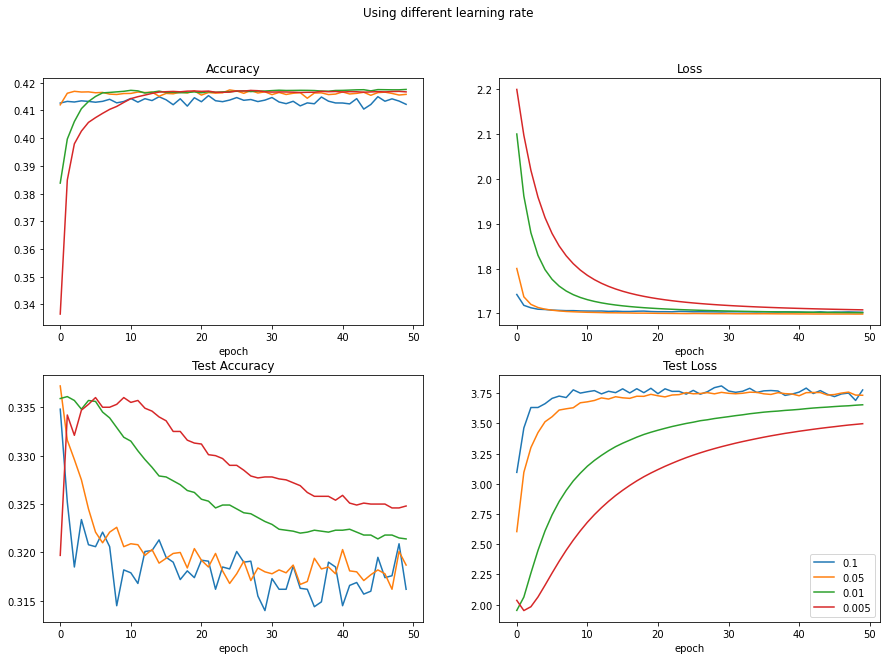

In [56]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05, 0.01, 0.005]
dropout_rate = 0

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['1f_lr_01', '1f_lr_005', '1f_lr_001', '1f_lr_0005']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2 FC-Layer

In [58]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    activation1 = ReLu()

    dense2 = dense(64,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)

            # Block 2
            dense2.forward(activation1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(dense2.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.3601 |loss: 1.8494 |test_acc:0.2902 |test_loss: 2.4378, |precision: 0.2902, |recall: 0.2902, |f1-score: 0.2902
Epochs 11/50 => acc:0.5770 |loss: 1.1996 |test_acc:0.3676 |test_loss: 3.4688, |precision: 0.3676, |recall: 0.3676, |f1-score: 0.3676
Epochs 21/50 => acc:0.5962 |loss: 1.1363 |test_acc:0.3659 |test_loss: 3.8554, |precision: 0.3659, |recall: 0.3659, |f1-score: 0.3659
Epochs 31/50 => acc:0.6072 |loss: 1.1124 |test_acc:0.3727 |test_loss: 3.7676, |precision: 0.3727, |recall: 0.3727, |f1-score: 0.3727
Epochs 41/50 => acc:0.6110 |loss: 1.0990 |test_acc:0.3714 |test_loss: 3.8386, |precision: 0.3714, |recall: 0.3714, |f1-score: 0.3714
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.2799 |loss: 2.2498 |test_acc:0.2400 |test_loss: 2.1793, |precision: 0.2400, |recall: 0.2400, |f1-score: 0.2400
Epochs 11/50 => acc:0.5364 |loss: 1.3201 |test_acc:0.3696 |test_loss: 3.0298, |precision: 0.

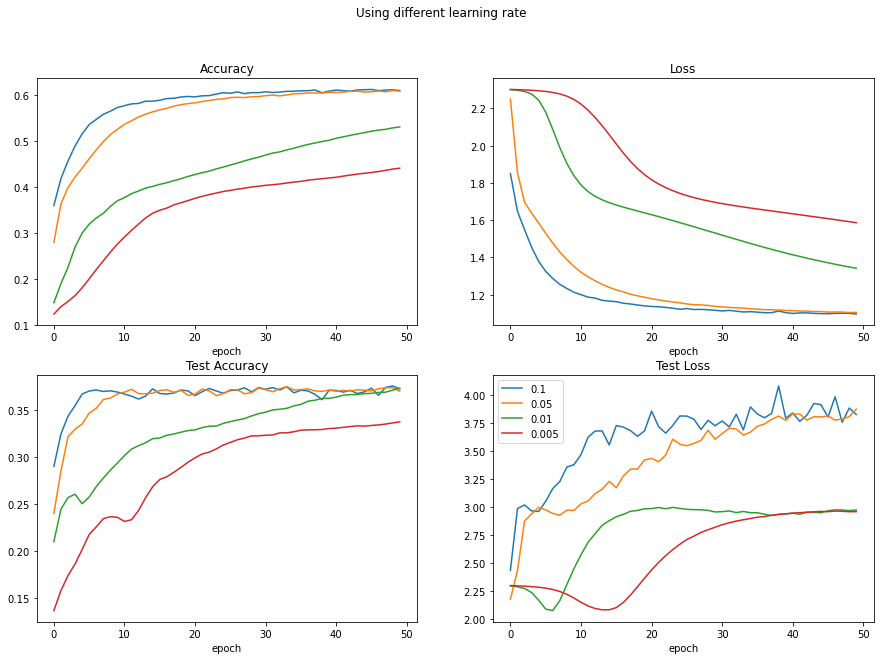

In [59]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05, 0.01, 0.005]
dropout_rate = 0

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['2f_lr_01', '2f_lr_005', '2f_lr_001', '2f_lr_0005']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 3 FC-Layer

In [60]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    activation1 = ReLu()

    dense2 = dense(64,32, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    activation2 = ReLu()

    dense3 = dense(32,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)

            # Block 2
            dense2.forward(activation1.output)
            activation2.forward(dense2.output)

            # Block 3
            dense3.forward(activation2.output)

            data_loss = loss_activation.forward(dense3.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + loss_activation.loss.regularization_loss(dense3)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense3.backward(loss_activation.dinputs)

            activation2.backward(dense3.dinputs)
            dense2.backward(activation2.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(dense2.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)
            optimizer.update_params(dense3)


            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        # Block 3 with (Dense)
        dense3.forward(activation2.output)
        
        train_val_loss = loss_activation.forward(dense3.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        #Block 2 with (Dense, ReLu)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)

        # Block 3 with (Dense)
        dense3.forward(activation2.output)

        testing_loss = loss_activation.forward(dense3.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.1000 |loss: 2.3025 |test_acc:0.1000 |test_loss: 2.3024, |precision: 0.1000, |recall: 0.1000, |f1-score: 0.1000
Epochs 11/50 => acc:0.5151 |loss: 1.3212 |test_acc:0.3567 |test_loss: 3.1652, |precision: 0.3567, |recall: 0.3567, |f1-score: 0.3567
Epochs 21/50 => acc:0.5848 |loss: 1.1488 |test_acc:0.3660 |test_loss: 3.6359, |precision: 0.3660, |recall: 0.3660, |f1-score: 0.3660
Epochs 31/50 => acc:0.6064 |loss: 1.0927 |test_acc:0.3732 |test_loss: 3.7384, |precision: 0.3732, |recall: 0.3732, |f1-score: 0.3732
Epochs 41/50 => acc:0.6229 |loss: 1.0504 |test_acc:0.3747 |test_loss: 3.7934, |precision: 0.3747, |recall: 0.3747, |f1-score: 0.3747
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.1000 |loss: 2.3026 |test_acc:0.1000 |test_loss: 2.3026, |precision: 0.1000, |recall: 0.1000, |f1-score: 0.1000
Epochs 11/50 => acc:0.2879 |loss: 1.8199 |test_acc:0.2182 |test_loss: 2.7656, |precision: 0.

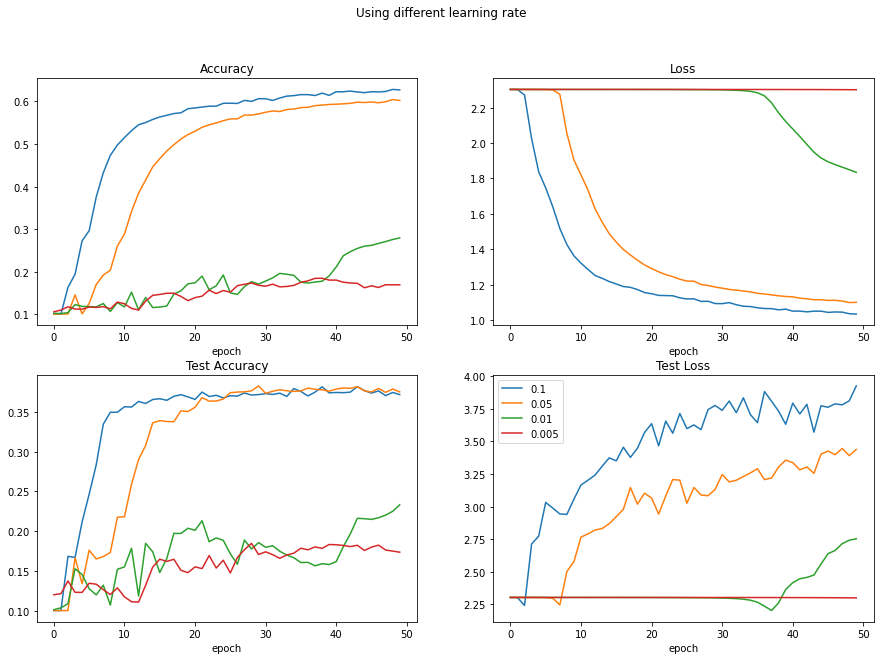

In [61]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05, 0.01, 0.005]
dropout_rate = 0

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['3f_lr_01', '3f_lr_005', '3f_lr_001', '3f_lr_0005']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2 FC-Layer with Dropout

In [74]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    activation1 = ReLu()
    dropout1 = Dropout(dropout_rate)

    dense2 = dense(64,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)
            dropout1.forward(activation1.output)

            # Block 2
            dense2.forward(dropout1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(dense2.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.1391 |loss: 2.3007 |test_acc:0.1644 |test_loss: 2.2989, |precision: 0.1644, |recall: 0.1644, |f1-score: 0.1644
Epochs 11/50 => acc:0.3818 |loss: 1.8045 |test_acc:0.3057 |test_loss: 2.4592, |precision: 0.3057, |recall: 0.3057, |f1-score: 0.3057
Epochs 21/50 => acc:0.4271 |loss: 1.6272 |test_acc:0.3315 |test_loss: 2.9570, |precision: 0.3315, |recall: 0.3315, |f1-score: 0.3315
Epochs 31/50 => acc:0.4658 |loss: 1.5226 |test_acc:0.3462 |test_loss: 2.9561, |precision: 0.3462, |recall: 0.3462, |f1-score: 0.3462
Epochs 41/50 => acc:0.5030 |loss: 1.4222 |test_acc:0.3632 |test_loss: 2.9244, |precision: 0.3632, |recall: 0.3632, |f1-score: 0.3632
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.1472 |loss: 2.3003 |test_acc:0.1938 |test_loss: 2.2976, |precision: 0.1938, |recall: 0.1938, |f1-score: 0.1938
Epochs 11/50 => acc:0.3804 |loss: 1.7901 |test_acc:0.3043 |test_loss: 2.5537, |precision: 0.

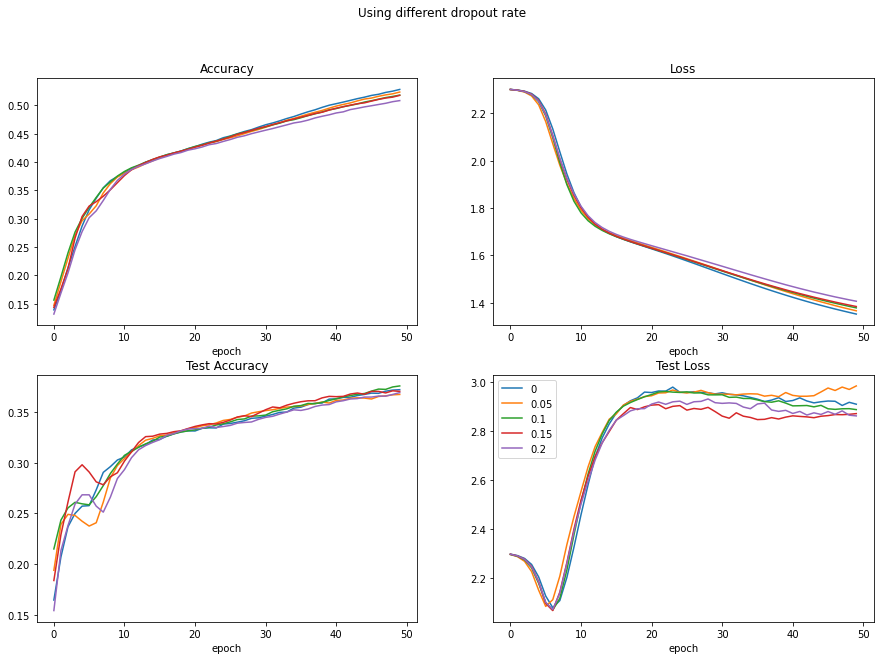

In [75]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.01
dropout_rate = [0,0.05,0.1,0.15,0.2]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in dropout_rate:
    experiment(epochs, batch_size, learning_rate, i, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=dropout_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=dropout_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=dropout_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=dropout_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different dropout rate, when lr = 0.01')
plt.legend()
plt.show()


test_name = ['2f_lr_001_dr_0','2f_lr_001_dr_005', '2f_lr_001_dr_01', '2f_lr_001_dr_015', '2f_lr_001_dr_02']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Training model...
------------------------------
Epochs 1/50 => acc:0.2992 |loss: 2.2355 |test_acc:0.2752 |test_loss: 2.1573, |precision: 0.2752, |recall: 0.2752, |f1-score: 0.2752
Epochs 11/50 => acc:0.5346 |loss: 1.3270 |test_acc:0.3756 |test_loss: 2.9841, |precision: 0.3756, |recall: 0.3756, |f1-score: 0.3756
Epochs 21/50 => acc:0.5822 |loss: 1.1848 |test_acc:0.3740 |test_loss: 3.3872, |precision: 0.3740, |recall: 0.3740, |f1-score: 0.3740
Epochs 31/50 => acc:0.5976 |loss: 1.1403 |test_acc:0.3747 |test_loss: 3.5943, |precision: 0.3747, |recall: 0.3747, |f1-score: 0.3747
Epochs 41/50 => acc:0.6042 |loss: 1.1191 |test_acc:0.3732 |test_loss: 3.7245, |precision: 0.3732, |recall: 0.3732, |f1-score: 0.3732
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.2693 |loss: 2.2542 |test_acc:0.2463 |test_loss: 2.1961, |precision: 0.2463, |recall: 0.2463, |f1-score: 0.2463
Epochs 11/50 => acc:0.5361 |loss: 1.3311 |test_acc:0.3694 |test_loss: 2.9957, |precision: 0.

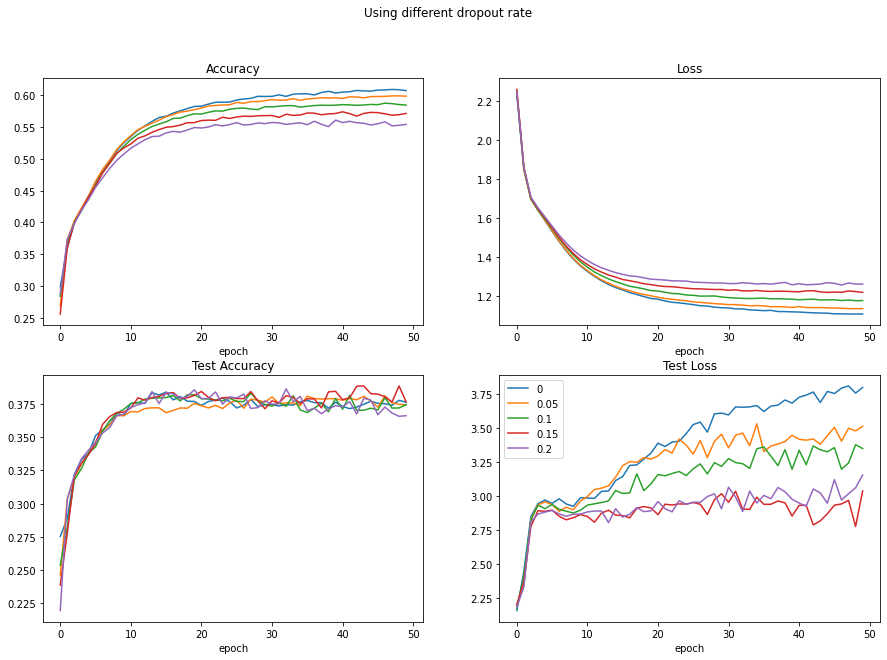

In [73]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.05
dropout_rate = [0,0.05,0.1,0.15,0.2]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in dropout_rate:
    experiment(epochs, batch_size, learning_rate, i, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=dropout_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=dropout_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=dropout_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=dropout_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different dropout rate, when lr = 0.05')
plt.legend()
plt.show()


test_name = ['2f_lr_005_dr_0','2f_lr_005_dr_005', '2f_lr_005_dr_01', '2f_lr_005_dr_015', '2f_lr_005_dr_02']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2 FC Layer with BN

In [ ]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    batch_norm1 = Batch_norm()
    activation1 = ReLu()

    dense2 = dense(64,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            batch_norm1.forward(dense1.output)
            activation1.forward(batch_norm1.output)

            # Block 2
            dense2.forward(activation1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(dense2.dinputs)
            batch_norm1.backward(activation1.dinputs)
            dense1.backward(batch_norm1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.3639 |loss: 1.8495 |test_acc:0.2863 |test_loss: 2.4480, |precision: 0.2863, |recall: 0.2863, |f1-score: 0.2863
Epochs 11/50 => acc:0.5739 |loss: 1.1982 |test_acc:0.3726 |test_loss: 3.4237, |precision: 0.3726, |recall: 0.3726, |f1-score: 0.3726
Epochs 21/50 => acc:0.5983 |loss: 1.1357 |test_acc:0.3763 |test_loss: 3.6431, |precision: 0.3763, |recall: 0.3763, |f1-score: 0.3763
Epochs 31/50 => acc:0.6026 |loss: 1.1173 |test_acc:0.3739 |test_loss: 3.9064, |precision: 0.3739, |recall: 0.3739, |f1-score: 0.3739
Epochs 41/50 => acc:0.6070 |loss: 1.1043 |test_acc:0.3721 |test_loss: 3.9027, |precision: 0.3721, |recall: 0.3721, |f1-score: 0.3721
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.2815 |loss: 2.2517 |test_acc:0.2461 |test_loss: 2.1880, |precision: 0.2461, |recall: 0.2461, |f1-score: 0.2461
Epochs 11/50 => acc:0.5338 |loss: 1.3347 |test_acc:0.3691 |test_loss: 2.9707, |precision: 0.

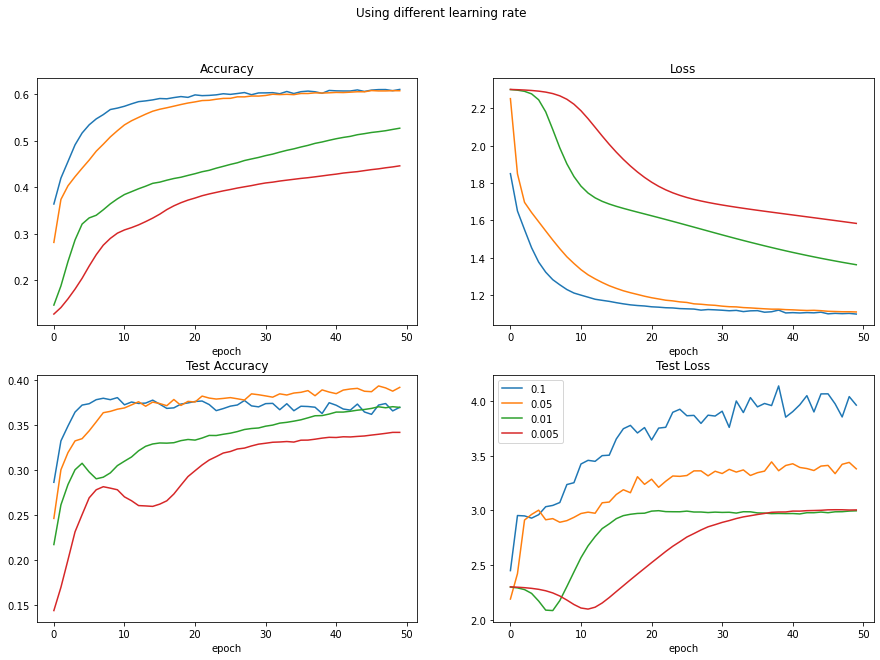

In [76]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05, 0.01, 0.005]
dropout_rate = 0

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different learning rate with batch normalization')
plt.legend()
plt.show()


test_name = ['2f_bn_lr_01', '2f_bn_lr_005', '2f_bn_lr_001', '2f_bn_lr_0005']
acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2 FC-Layer with Dropout + BN

In [79]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 0,b_regularizer_l2 = 0)
    batch_norm1 = Batch_norm()
    activation1 = ReLu()
    dropout1 = Dropout(dropout_rate)

    dense2 = dense(64,10, w_regularizer_l2 = 0,b_regularizer_l2 = 0)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            batch_norm1.forward(dense1.output)
            activation1.forward(batch_norm1.output)
            dropout1.forward(activation1.output)

            # Block 2
            dense2.forward(dropout1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            dropout1.backward(dense2.dinputs)
            activation1.backward(dropout1.dinputs)
            batch_norm1.backward(activation1.dinputs)
            dense1.backward(batch_norm1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            # optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.4575 |loss: 1.5480 |test_acc:0.3667 |test_loss: 1.8271, |precision: 0.3667, |recall: 0.3667, |f1-score: 0.3667
Epochs 11/50 => acc:0.5847 |loss: 1.1855 |test_acc:0.4255 |test_loss: 1.8439, |precision: 0.4255, |recall: 0.4255, |f1-score: 0.4255
Epochs 21/50 => acc:0.6025 |loss: 1.1345 |test_acc:0.4278 |test_loss: 1.8702, |precision: 0.4278, |recall: 0.4278, |f1-score: 0.4278
Epochs 31/50 => acc:0.6078 |loss: 1.1149 |test_acc:0.4286 |test_loss: 1.9204, |precision: 0.4286, |recall: 0.4286, |f1-score: 0.4286
Epochs 41/50 => acc:0.6117 |loss: 1.1015 |test_acc:0.4278 |test_loss: 1.9500, |precision: 0.4278, |recall: 0.4278, |f1-score: 0.4278
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.4572 |loss: 1.5595 |test_acc:0.3778 |test_loss: 1.8077, |precision: 0.3778, |recall: 0.3778, |f1-score: 0.3778
Epochs 11/50 => acc:0.5783 |loss: 1.2121 |test_acc:0.4105 |test_loss: 1.8702, |precision: 0.

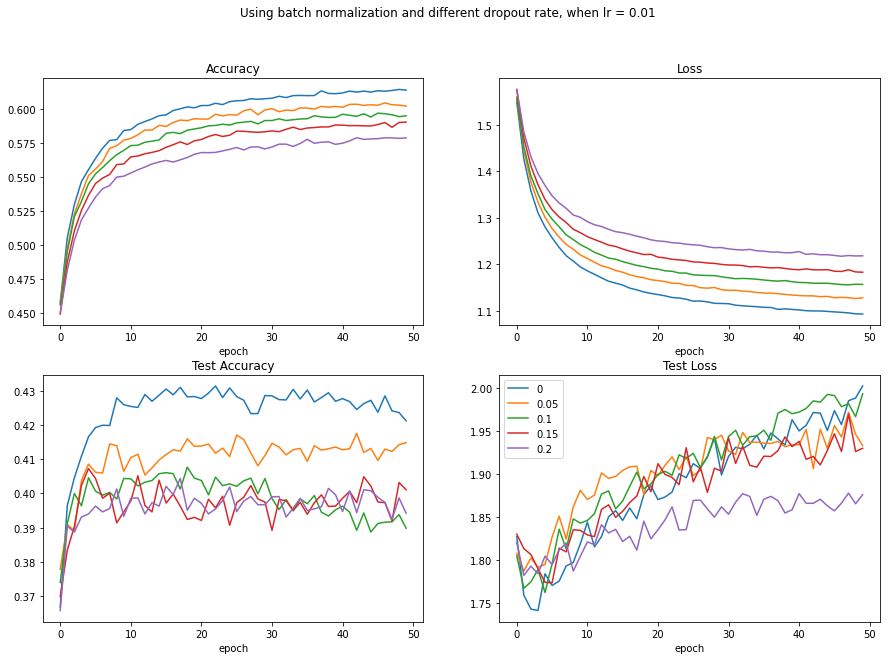

In [80]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.1
dropout_rate = [0,0.05,0.1,0.15,0.2]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in dropout_rate:
    experiment(epochs, batch_size, learning_rate, i, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=dropout_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=dropout_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=dropout_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=dropout_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using batch normalization and different dropout rate, when lr = 0.01')
plt.legend()
plt.show()


test_name = ['2f_lr_bn_01_dr_0','2f_lr_bn_01_dr_01', '2f_lr_bn_01_dr_02']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Training model...
------------------------------
Epochs 1/50 => acc:0.4384 |loss: 1.6113 |test_acc:0.3616 |test_loss: 1.8261, |precision: 0.3616, |recall: 0.3616, |f1-score: 0.3616
Epochs 11/50 => acc:0.5751 |loss: 1.2315 |test_acc:0.4168 |test_loss: 1.8090, |precision: 0.4168, |recall: 0.4168, |f1-score: 0.4168
Epochs 21/50 => acc:0.5964 |loss: 1.1631 |test_acc:0.4195 |test_loss: 1.8469, |precision: 0.4195, |recall: 0.4195, |f1-score: 0.4195
Epochs 31/50 => acc:0.6032 |loss: 1.1352 |test_acc:0.4203 |test_loss: 1.8958, |precision: 0.4203, |recall: 0.4203, |f1-score: 0.4203
Epochs 41/50 => acc:0.6093 |loss: 1.1176 |test_acc:0.4184 |test_loss: 1.9294, |precision: 0.4184, |recall: 0.4184, |f1-score: 0.4184
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.4378 |loss: 1.6152 |test_acc:0.3647 |test_loss: 1.8327, |precision: 0.3647, |recall: 0.3647, |f1-score: 0.3647
Epochs 11/50 => acc:0.5693 |loss: 1.2493 |test_acc:0.4168 |test_loss: 1.7760, |precision: 0.

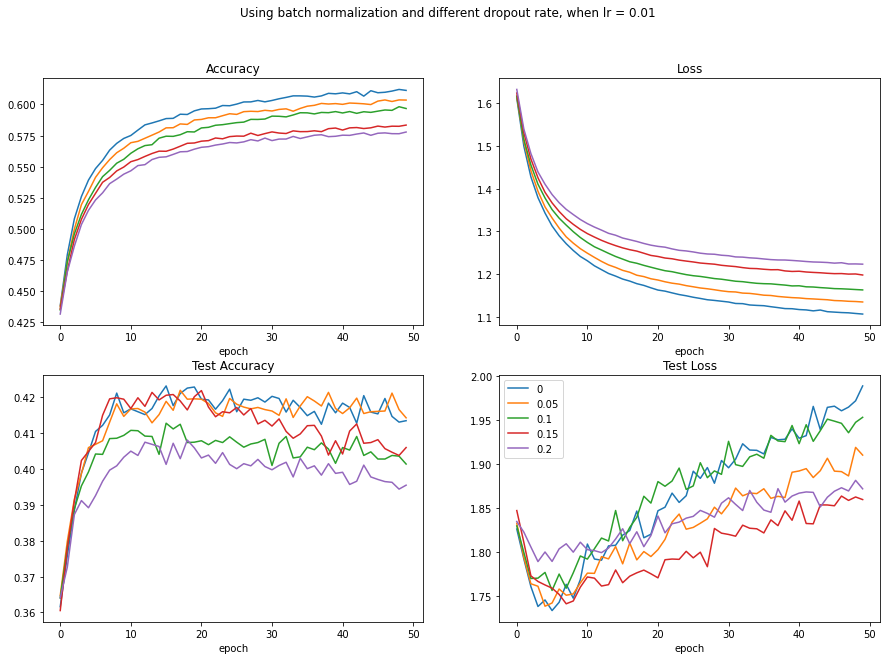

In [81]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.05
dropout_rate = [0,0.05,0.1,0.15,0.2]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in dropout_rate:
    experiment(epochs, batch_size, learning_rate, i, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=dropout_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=dropout_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=dropout_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=dropout_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using batch normalization and different dropout rate, when lr = 0.01')
plt.legend()
plt.show()


test_name = ['2f_lr_bn_01_dr_0','2f_lr_bn_01_dr_01', '2f_lr_bn_01_dr_02']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2 FC with weight-decay 

In [87]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = weight_decay,b_regularizer_l2 = weight_decay)
    activation1 = ReLu()

    dense2 = dense(64,16, w_regularizer_l2 = weight_decay,b_regularizer_l2 = weight_decay)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)

            # Block 2
            dense2.forward(activation1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            # dropout1.backward(dense2.dinputs)
            activation1.backward(dense2.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.3465 |loss: 1.9635 |test_acc:0.2724 |test_loss: 2.2507, |precision: 0.2724, |recall: 0.2724, |f1-score: 0.2724
Epochs 11/50 => acc:0.4632 |loss: 1.5352 |test_acc:0.3465 |test_loss: 2.8966, |precision: 0.3465, |recall: 0.3465, |f1-score: 0.3465
Epochs 21/50 => acc:0.4911 |loss: 1.4528 |test_acc:0.3580 |test_loss: 2.8720, |precision: 0.3580, |recall: 0.3580, |f1-score: 0.3580
Epochs 31/50 => acc:0.5079 |loss: 1.4076 |test_acc:0.3646 |test_loss: 2.8595, |precision: 0.3646, |recall: 0.3646, |f1-score: 0.3646
Epochs 41/50 => acc:0.5178 |loss: 1.3785 |test_acc:0.3676 |test_loss: 2.8650, |precision: 0.3676, |recall: 0.3676, |f1-score: 0.3676
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.3596 |loss: 1.9822 |test_acc:0.2967 |test_loss: 2.1782, |precision: 0.2967, |recall: 0.2967, |f1-score: 0.2967
Epochs 11/50 => acc:0.4611 |loss: 1.5423 |test_acc:0.3525 |test_loss: 2.8754, |precision: 0.

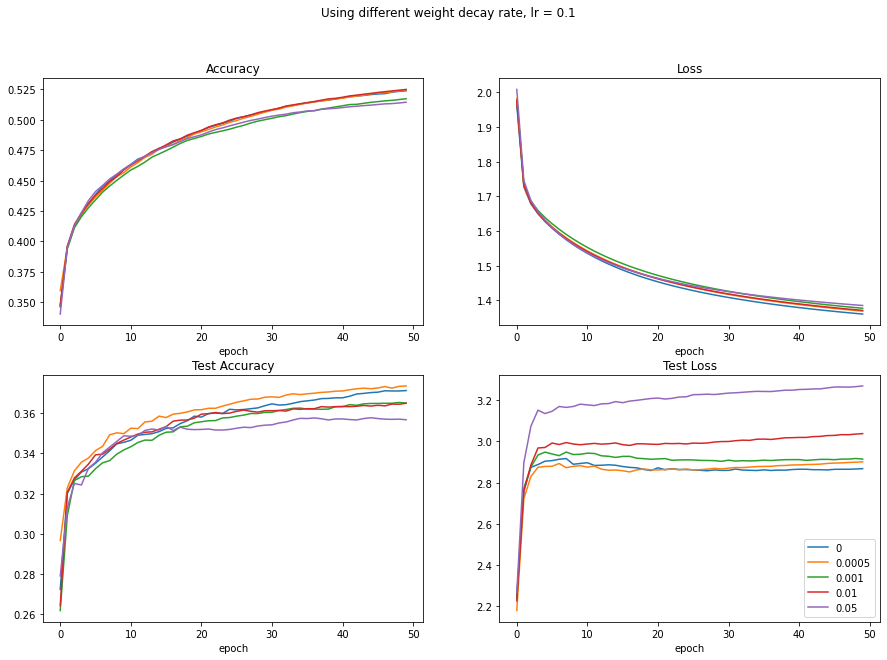

In [88]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.1
dropout_rate = 0
weight_decay = [0, 0.0005, 0.001, 0.01, 0.05]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in weight_decay:
    experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, i)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=weight_decay[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=weight_decay[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=weight_decay[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=weight_decay[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different weight decay rate, lr = 0.1')
plt.legend()
plt.show()


test_name = ['2f_wg_0_lr_01', '2f_wg_00005_lr_01', '2f_wg_0001_lr_01', '2f_wg_001_lr_01', '2f_wg_005_lr_01']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Training model...
------------------------------
Epochs 1/50 => acc:0.2014 |loss: 2.4251 |test_acc:0.2460 |test_loss: 2.3589, |precision: 0.2460, |recall: 0.2460, |f1-score: 0.2460
Epochs 11/50 => acc:0.4074 |loss: 1.6915 |test_acc:0.3254 |test_loss: 2.8720, |precision: 0.3254, |recall: 0.3254, |f1-score: 0.3254
Epochs 21/50 => acc:0.4218 |loss: 1.6521 |test_acc:0.3328 |test_loss: 2.9215, |precision: 0.3328, |recall: 0.3328, |f1-score: 0.3328
Epochs 31/50 => acc:0.4308 |loss: 1.6294 |test_acc:0.3367 |test_loss: 2.9289, |precision: 0.3367, |recall: 0.3367, |f1-score: 0.3367
Epochs 41/50 => acc:0.4369 |loss: 1.6125 |test_acc:0.3385 |test_loss: 2.9276, |precision: 0.3385, |recall: 0.3385, |f1-score: 0.3385
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.2101 |loss: 2.4387 |test_acc:0.2474 |test_loss: 2.3919, |precision: 0.2474, |recall: 0.2474, |f1-score: 0.2474
Epochs 11/50 => acc:0.4082 |loss: 1.6887 |test_acc:0.3250 |test_loss: 2.8452, |precision: 0.

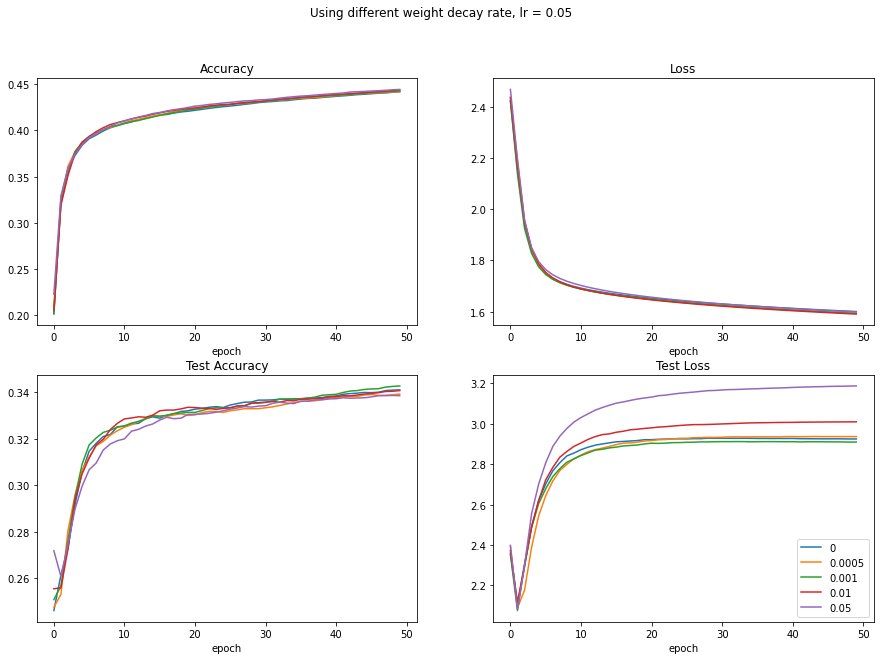

In [89]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = 0.05
dropout_rate = 0
weight_decay = [0, 0.0005, 0.001, 0.01, 0.05]

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in weight_decay:
    experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, i)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=weight_decay[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=weight_decay[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=weight_decay[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=weight_decay[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using different weight decay rate, lr = 0.05')
plt.legend()
plt.show()


test_name = ['2f_wg_0_lr_005', '2f_wg_00005_lr_005', '2f_wg_0001_lr_005', '2f_wg_001_lr_005', '2f_wg_005_lr_005']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

# 2-FC layer with Dropout + weight decay

In [27]:
# def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

#     # Model architecture
#     dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     activation1 = ReLu()
#     dropout1 = Dropout(dropout_rate)

#     dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     loss_activation = softmax_crossentropy_loss()

#     optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

#     # Create list to save the accuracies and losses during training
#     acc_train = []
#     loss_train = []

#     for epoch in range(epochs):
        
#         # Mini-batch SGD
#         for batch in create_batches(X_train, y_train, batch_size):
#             x_batch, y_batch = batch
            
#             # Block 1 with (Dense, BN, Relu, Dropout)
#             dense1.forward(x_batch)
#             activation1.forward(dense1.output)
#             dropout1.forward(activation1.output)
            
#             # Block 2 with (Dense)
#             dense2.forward(dropout1.output)
#             data_loss = loss_activation.forward(dense2.output, y_batch)

#             # Add up the regularization loss
#             regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

#             # Calculate the total loss of this epoch training for visualization later
#             loss = data_loss + regularization_loss

#             # Backpropagation
#             loss_activation.backward(loss_activation.output, y_batch)
#             dense2.backward(loss_activation.dinputs)


#             activation1.backward(dense2.dinputs)
#             dense1.backward(activation1.dinputs)

#             # Update optimizer paramters
#             optimizer.pre_update()

#             # Update the weights and bias in the dense layers
#             optimizer.update_params(dense1)
#             optimizer.update_params(dense2)

#             # Iteration + 1 for SGD with momentum
#             optimizer.post_update()

#         # Make a forward pass using the training set and calculate the accuracy and loss
#         dense1.forward(X_train)
#         activation1.forward(dense1.output)
#         dropout1.forward(activation1.output)
        
#         dense2.forward(dropout1.output)
#         val_loss = loss_activation.forward(dense2.output, y_train)

#         prediction = np.argmax(loss_activation.output, axis=1)
#         if len(y_train) == 2:
#             y_train = np.argmax(y_train, axis=1)
#         accuracy = np.mean(y_train==prediction)
        
#         # Save the accuracy and loss for visualization
#         acc_train.append(accuracy)
#         loss_train.append(val_loss)

#     all_acc.append(acc_train)
#     all_loss.append(loss_train)

#     # Evaluate on the test set
#     dense1.forward(X_test)
#     activation1.forward(dense1.output)
#     dropout1.forward(activation1.output)

#     dense2.forward(dropout1.output)
#     loss = loss_activation.forward(dense2.output, y_test)
#     prediction = np.argmax(loss_activation.output, axis=1)

#     if len(y_test) == 2:
#         y_test = np.argmax(y_test, axis=1)
#     accuracy = np.mean(y_test==prediction)

#     print("Testing accuracy")
#     print("-"*50)
#     print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

#     print("Done training")
#     test_acc.append(accuracy)
#     test_loss.append(loss)

#     return all_acc, all_loss




In [91]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    activation1 = ReLu()
    dropout1 = Dropout(dropout_rate)

    dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)
            dropout1.forward(activation1.output)

            # Block 2
            dense2.forward(dropout1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            dropout1.backward(dense2.dinputs)
            activation1.backward(dropout1.dinputs)
            # batch_norm1.backward(activation1.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            # optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        activation1.forward(dense1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.3464 |loss: 1.9720 |test_acc:0.2681 |test_loss: 2.2333, |precision: 0.2681, |recall: 0.2681, |f1-score: 0.2681
Epochs 11/50 => acc:0.4580 |loss: 1.5528 |test_acc:0.3442 |test_loss: 2.9387, |precision: 0.3442, |recall: 0.3442, |f1-score: 0.3442
Epochs 21/50 => acc:0.4864 |loss: 1.4736 |test_acc:0.3576 |test_loss: 2.9202, |precision: 0.3576, |recall: 0.3576, |f1-score: 0.3576
Epochs 31/50 => acc:0.5022 |loss: 1.4280 |test_acc:0.3608 |test_loss: 2.9358, |precision: 0.3608, |recall: 0.3608, |f1-score: 0.3608
Epochs 41/50 => acc:0.5130 |loss: 1.3981 |test_acc:0.3643 |test_loss: 2.9512, |precision: 0.3643, |recall: 0.3643, |f1-score: 0.3643
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.2509 |loss: 2.4341 |test_acc:0.2650 |test_loss: 2.3733, |precision: 0.2650, |recall: 0.2650, |f1-score: 0.2650
Epochs 11/50 => acc:0.4081 |loss: 1.6909 |test_acc:0.3224 |test_loss: 2.8797, |precision: 0.

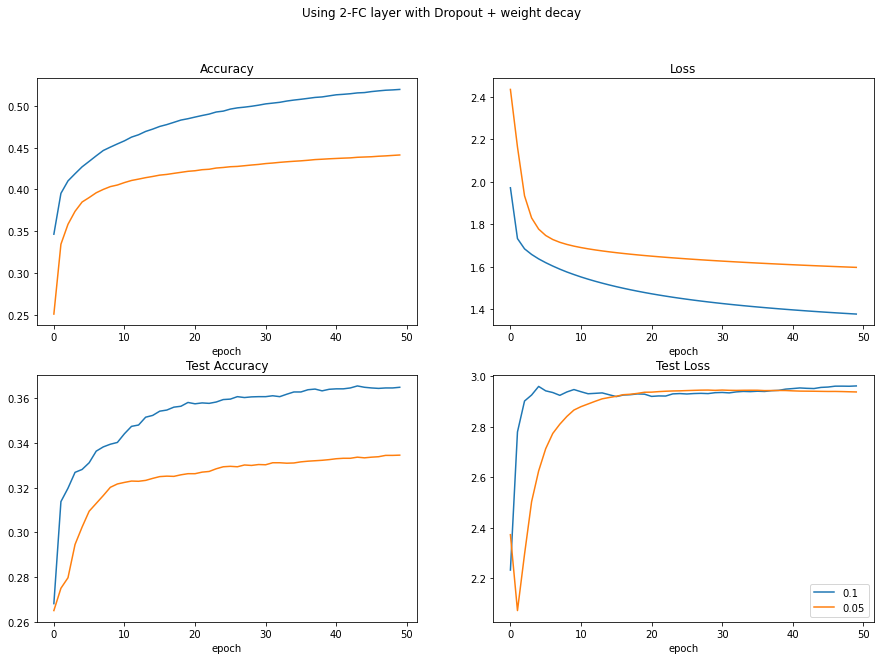

In [92]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05]
dropout_rate = 0.02
weight_decay = 0.0005

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")


fig.suptitle('Using 2-FC layer with Dropout + weight decay')
plt.legend()
plt.show()


test_name = ['2f_dr_02_wg_00005_lr_01', '2f_dr_02_wg_00005_lr_005']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Testing accuracy
--------------------------------------------------
acc:0.3508 |loss:2.9427
Done training
Testing accuracy
--------------------------------------------------
acc:0.3280 |loss:2.9301
Done training


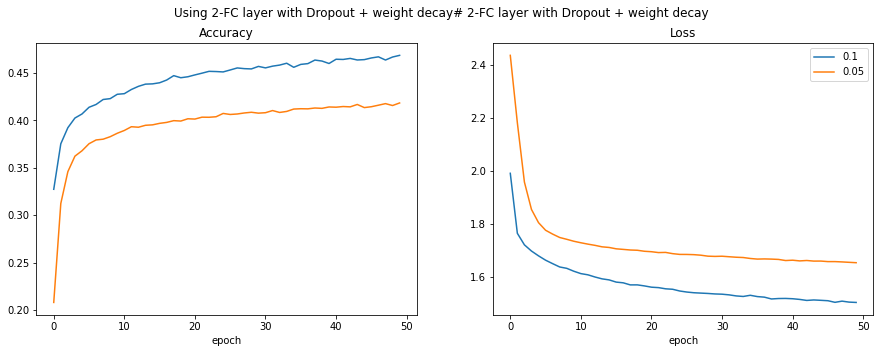

In [28]:
# #Set some of the paramaters for the training process
# epochs = 50
# batch_size = 128
# learning_rate = [0.1, 0.05]
# dropout_rate = 0.2
# weight_decay = 0.0005

# all_acc = []
# all_loss = []
# test_acc = []
# test_loss = []

# for i in learning_rate:
#     experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)

# fig, axs = plt.subplots(1,2, figsize=(15,5))

# for label, i in enumerate(all_acc):
#     axs[0].plot(i, label=learning_rate[label])

# axs[0].set_title("Accuracy")
# axs[0].set_xlabel("epoch")

# for label, i in enumerate(all_loss):
#     axs[1].plot(i, label=learning_rate[label])
# axs[1].set_title("Loss")
# axs[1].set_xlabel("epoch")


# fig.suptitle('Using 2-FC layer with Dropout + weight decay# 2-FC layer with Dropout + weight decay')
# plt.legend()
# plt.show()


# # Concat the results
# test_name = ['2f_dr_02_wg_00005_lr_01', '2f_dr_02_wg_00005_lr_005']

# acc_train_df, loss_train_df, acc_test_series, loss_test_series = \
#     save_info_df(acc_train_df, loss_train_df, acc_test_series, loss_test_series, test_name, new=False)

# 2-FC layer with Dropout + BN + weight decay 

In [29]:
# def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

#     # Model architecture
#     dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     batch_norm1 = Batch_norm()
#     activation1 = ReLu()
#     dropout1 = Dropout(dropout_rate)

#     dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     loss_activation = softmax_crossentropy_loss()

#     optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

#     # Create list to save the accuracies and losses during training
#     acc_train = []
#     loss_train = []

#     for epoch in range(epochs):
        
#         # Mini-batch SGD
#         for batch in create_batches(X_train, y_train, batch_size):
#             x_batch, y_batch = batch
            
#             # Block 1 with (Dense, BN, Relu, Dropout)
#             dense1.forward(x_batch)
#             batch_norm1.forward(dense1.output)
#             activation1.forward(batch_norm1.output)
#             dropout1.forward(activation1.output)
            
#             # Block 2 with (Dense)
#             dense2.forward(dropout1.output)
#             data_loss = loss_activation.forward(dense2.output, y_batch)

#             # Add up the regularization loss
#             regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

#             # Calculate the total loss of this epoch training for visualization later
#             loss = data_loss + regularization_loss

#             # Backpropagation
#             loss_activation.backward(loss_activation.output, y_batch)
#             dense2.backward(loss_activation.dinputs)

#             dropout1.backward(dense2.dinputs)
#             activation1.backward(dropout1.dinputs)
#             batch_norm1.backward(activation1.dinputs)
#             dense1.backward(batch_norm1.dinputs)

#             # Update optimizer paramters
#             optimizer.pre_update()

#             # Update the weights and bias in the dense layers
#             optimizer.update_params(dense1)
#             optimizer.update_params(dense2)

#             # Update the learnable gamma and beta in batch normalization
#             optimizer.update_BN_param(batch_norm1)

#             # Iteration + 1 for SGD with momentum
#             optimizer.post_update()

#         # Make a forward pass using the training set and calculate the accuracy and loss

#         # Block 1 with (Dense, Relu, Dropout)
#         dense1.forward(X_train)
#         batch_norm1.forward(dense1.output)
#         activation1.forward(batch_norm1.output)
#         dropout1.forward(activation1.output)
        
#         dense2.forward(dropout1.output)

#         val_loss = loss_activation.forward(dense2.output, y_train)

#         prediction = np.argmax(loss_activation.output, axis=1)
#         if len(y_train) == 2:
#             y_train = np.argmax(y_train, axis=1)
#         accuracy = np.mean(y_train==prediction)
        
#         # Save the accuracy and loss for visualization
#         acc_train.append(accuracy)
#         loss_train.append(val_loss)

#     all_acc.append(acc_train)
#     all_loss.append(loss_train)

#     # Evaluate on the test set
#     dense1.forward(X_test)
#     batch_norm1.forward(dense1.output)
#     activation1.forward(batch_norm1.output)
#     dropout1.forward(activation1.output)

#     dense2.forward(dropout1.output)
#     loss = loss_activation.forward(dense2.output, y_test)
#     prediction = np.argmax(loss_activation.output, axis=1)

#     if len(y_test) == 2:
#         y_test = np.argmax(y_test, axis=1)
#     accuracy = np.mean(y_test==prediction)

#     print("Testing accuracy")
#     print("-"*50)
#     print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

#     print("Done training")
#     test_acc.append(accuracy)
#     test_loss.append(loss)

#     return all_acc, all_loss

In [93]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    batch_norm1 = Batch_norm()
    activation1 = ReLu()
    dropout1 = Dropout(dropout_rate)

    dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            batch_norm1.forward(dense1.output)
            activation1.forward(batch_norm1.output)
            dropout1.forward(activation1.output)

            # Block 2
            dense2.forward(dropout1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            dropout1.backward(dense2.dinputs)
            activation1.backward(dropout1.dinputs)
            batch_norm1.backward(activation1.dinputs)
            dense1.backward(batch_norm1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.4530 |loss: 1.5832 |test_acc:0.3730 |test_loss: 1.8311, |precision: 0.3730, |recall: 0.3730, |f1-score: 0.3730
Epochs 11/50 => acc:0.5517 |loss: 1.3074 |test_acc:0.4102 |test_loss: 1.7781, |precision: 0.4102, |recall: 0.4102, |f1-score: 0.4102
Epochs 21/50 => acc:0.5637 |loss: 1.2658 |test_acc:0.4135 |test_loss: 1.7931, |precision: 0.4135, |recall: 0.4135, |f1-score: 0.4135
Epochs 31/50 => acc:0.5704 |loss: 1.2457 |test_acc:0.4151 |test_loss: 1.7986, |precision: 0.4151, |recall: 0.4151, |f1-score: 0.4151
Epochs 41/50 => acc:0.5739 |loss: 1.2333 |test_acc:0.4156 |test_loss: 1.8056, |precision: 0.4156, |recall: 0.4156, |f1-score: 0.4156
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.4337 |loss: 1.6529 |test_acc:0.3573 |test_loss: 1.8716, |precision: 0.3573, |recall: 0.3573, |f1-score: 0.3573
Epochs 11/50 => acc:0.5245 |loss: 1.3917 |test_acc:0.4005 |test_loss: 1.7687, |precision: 0.

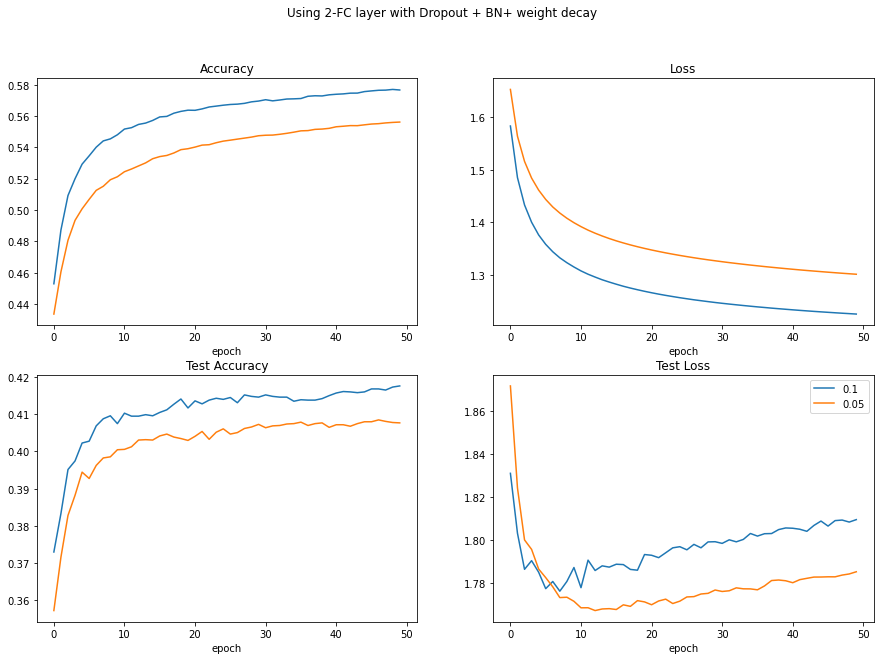

In [94]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05]
dropout_rate = 0
weight_decay = 0.0005

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")

fig.suptitle('Using 2-FC layer with Dropout + BN + weight decay')
plt.legend()
plt.show()


test_name = ['2f_dr_02_wg_00005_lr_01_bn', '2f_dr_02_wg_00005_lr_005_bn']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Testing accuracy
--------------------------------------------------
acc:0.4191 |loss:1.8152
Done training
Testing accuracy
--------------------------------------------------
acc:0.4063 |loss:1.8184
Done training


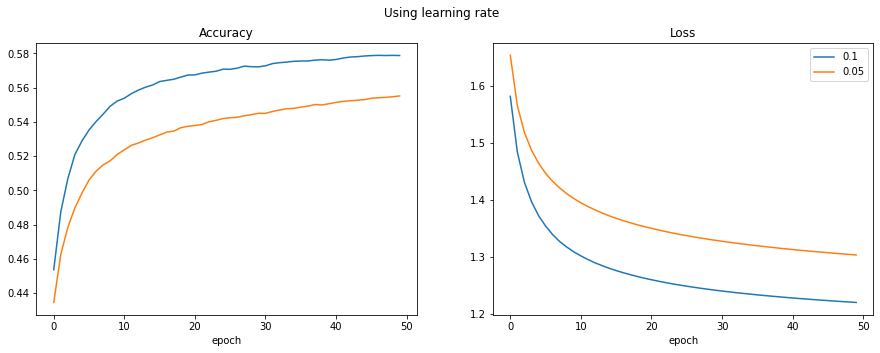

In [30]:
# #Set some of the paramaters for the training process
# epochs = 50
# batch_size = 128
# learning_rate = [0.1, 0.05]
# dropout_rate = 0
# weight_decay = 0.0005

# all_acc = []
# all_loss = []
# test_acc = []
# test_loss = []

# for i in learning_rate:
#     experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)

# fig, axs = plt.subplots(1,2, figsize=(15,5))

# for label, i in enumerate(all_acc):
#     axs[0].plot(i, label=learning_rate[label])

# axs[0].set_title("Accuracy")
# axs[0].set_xlabel("epoch")

# for label, i in enumerate(all_loss):
#     axs[1].plot(i, label=learning_rate[label])
# axs[1].set_title("Loss")
# axs[1].set_xlabel("epoch")


# fig.suptitle('Using learning rate')
# plt.legend()
# plt.show()


# # Concat the results
# test_name = ['2f_dr_02_wg_00005_lr_01_bn', '2f_dr_02_wg_00005_lr_005_bn']

# acc_train_df, loss_train_df, acc_test_series, loss_test_series = \
#     save_info_df(acc_train_df, loss_train_df, acc_test_series, loss_test_series, test_name, new=False)

# 2-FC layer with Dropout + BN + weight decay + Momentum in SGD 

In [31]:
# def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

#     # Model architecture
#     dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     batch_norm1 = Batch_norm()
#     activation1 = ReLu()
#     dropout1 = Dropout(dropout_rate)

#     dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
#     loss_activation = softmax_crossentropy_loss()

#     optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum=False)

#     # Create list to save the accuracies and losses during training
#     acc_train = []
#     loss_train = []

#     for epoch in range(epochs):
        
#         # Mini-batch SGD
#         for batch in create_batches(X_train, y_train, batch_size):
#             x_batch, y_batch = batch
            
#             # Block 1 with (Dense, BN, Relu, Dropout)
#             dense1.forward(x_batch)
#             batch_norm1.forward(dense1.output)
#             activation1.forward(batch_norm1.output)
#             dropout1.forward(activation1.output)
            
#             # Block 2 with (Dense)
#             dense2.forward(dropout1.output)
#             data_loss = loss_activation.forward(dense2.output, y_batch)

#             # Add up the regularization loss
#             regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

#             # Calculate the total loss of this epoch training for visualization later
#             loss = data_loss + regularization_loss

#             # Backpropagation
#             loss_activation.backward(loss_activation.output, y_batch)
#             dense2.backward(loss_activation.dinputs)

#             dropout1.backward(dense2.dinputs)
#             activation1.backward(dropout1.dinputs)
#             batch_norm1.backward(activation1.dinputs)
#             dense1.backward(batch_norm1.dinputs)

#             # Update optimizer paramters
#             optimizer.pre_update()

#             # Update the weights and bias in the dense layers
#             optimizer.update_params(dense1)
#             optimizer.update_params(dense2)

#             # Update the learnable gamma and beta in batch normalization
#             optimizer.update_BN_param(batch_norm1)

#             # Iteration + 1 for SGD with momentum
#             optimizer.post_update()

#         # Make a forward pass using the training set and calculate the accuracy and loss

#         # Block 1 with (Dense, Relu, Dropout)
#         dense1.forward(X_train)
#         batch_norm1.forward(dense1.output)
#         activation1.forward(batch_norm1.output)
#         dropout1.forward(activation1.output)
        
#         dense2.forward(dropout1.output)

#         val_loss = loss_activation.forward(dense2.output, y_train)

#         prediction = np.argmax(loss_activation.output, axis=1)
#         if len(y_train) == 2:
#             y_train = np.argmax(y_train, axis=1)
#         accuracy = np.mean(y_train==prediction)
        
#         # Save the accuracy and loss for visualization
#         acc_train.append(accuracy)
#         loss_train.append(val_loss)

#     all_acc.append(acc_train)
#     all_loss.append(loss_train)

#     # Evaluate on the test set
#     dense1.forward(X_test)
#     batch_norm1.forward(dense1.output)
#     activation1.forward(batch_norm1.output)
#     dropout1.forward(activation1.output)

#     dense2.forward(dropout1.output)
#     loss = loss_activation.forward(dense2.output, y_test)
#     prediction = np.argmax(loss_activation.output, axis=1)

#     if len(y_test) == 2:
#         y_test = np.argmax(y_test, axis=1)
#     accuracy = np.mean(y_test==prediction)

#     print("Testing accuracy")
#     print("-"*50)
#     print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

#     print("Done training")
#     test_acc.append(accuracy)
#     test_loss.append(loss)

#     return all_acc, all_loss

In [101]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    batch_norm1 = Batch_norm()
    activation1 = ReLu()
    dropout1 = Dropout(dropout_rate)

    dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0.002, momentum= False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []
    test_acc = []
    test_loss = []

    print("Training model...")
    print("-"*30)

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN)
            dense1.forward(x_batch)
            batch_norm1.forward(dense1.output)
            activation1.forward(batch_norm1.output)
            dropout1.forward(activation1.output)

            # Block 2
            dense2.forward(dropout1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            dropout1.backward(dense2.dinputs)
            activation1.backward(dropout1.dinputs)
            batch_norm1.backward(activation1.dinputs)
            dense1.backward(batch_norm1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Update the learnable gamma and beta in batch normalization
            optimizer.update_BN_param(batch_norm1)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and test set

        # Block 1 with (Dense, Relu)
        dense1.forward(X_train)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)
        
        train_val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        train_accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(train_accuracy)
        loss_train.append(train_val_loss)

        # Evaluate on the test set
        dense1.forward(X_test)
        batch_norm1.forward(dense1.output)
        activation1.forward(batch_norm1.output)

        #Block 2 with (Dense)
        dense2.forward(activation1.output)

        testing_loss = loss_activation.forward(dense2.output, y_test)
        prediction = np.argmax(loss_activation.output, axis=1)

        if len(y_test) == 2:
            y_test = np.argmax(y_test, axis=1)
        testing_accuracy = np.mean(y_test==prediction)

        # TP/ (TP + FP)
        # p, r, f = confusion_matrix(y_test, prediction)
        p, r, f = confusion_matrix(prediction, y_test)

        test_acc.append(testing_accuracy)
        test_loss.append(testing_loss)

        if epoch % 10 == 0:
            print(f"Epochs {epoch+1}/{epochs} => acc:{train_accuracy:.4f} |loss: {train_val_loss:.4f} |test_acc:{testing_accuracy:.4f} |test_loss: {testing_loss:.4f}, |precision: {p:.4f}, |recall: {r:.4f}, |f1-score: {f:.4f}")

    all_acc.append(acc_train)
    all_loss.append(loss_train)
    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    
    print('Done Training')
    print('='* 50)


    return all_acc, all_loss, all_test_acc, all_test_loss

Training model...
------------------------------
Epochs 1/50 => acc:0.4533 |loss: 1.5759 |test_acc:0.3608 |test_loss: 1.8563, |precision: 0.3608, |recall: 0.3608, |f1-score: 0.3608
Epochs 11/50 => acc:0.5527 |loss: 1.3010 |test_acc:0.4123 |test_loss: 1.7618, |precision: 0.4123, |recall: 0.4123, |f1-score: 0.4123
Epochs 21/50 => acc:0.5661 |loss: 1.2593 |test_acc:0.4148 |test_loss: 1.7774, |precision: 0.4148, |recall: 0.4148, |f1-score: 0.4148
Epochs 31/50 => acc:0.5728 |loss: 1.2394 |test_acc:0.4168 |test_loss: 1.7881, |precision: 0.4168, |recall: 0.4168, |f1-score: 0.4168
Epochs 41/50 => acc:0.5752 |loss: 1.2272 |test_acc:0.4160 |test_loss: 1.7951, |precision: 0.4160, |recall: 0.4160, |f1-score: 0.4160
Done Training
Training model...
------------------------------
Epochs 1/50 => acc:0.4330 |loss: 1.6488 |test_acc:0.3593 |test_loss: 1.8632, |precision: 0.3593, |recall: 0.3593, |f1-score: 0.3593
Epochs 11/50 => acc:0.5229 |loss: 1.3919 |test_acc:0.3937 |test_loss: 1.7807, |precision: 0.

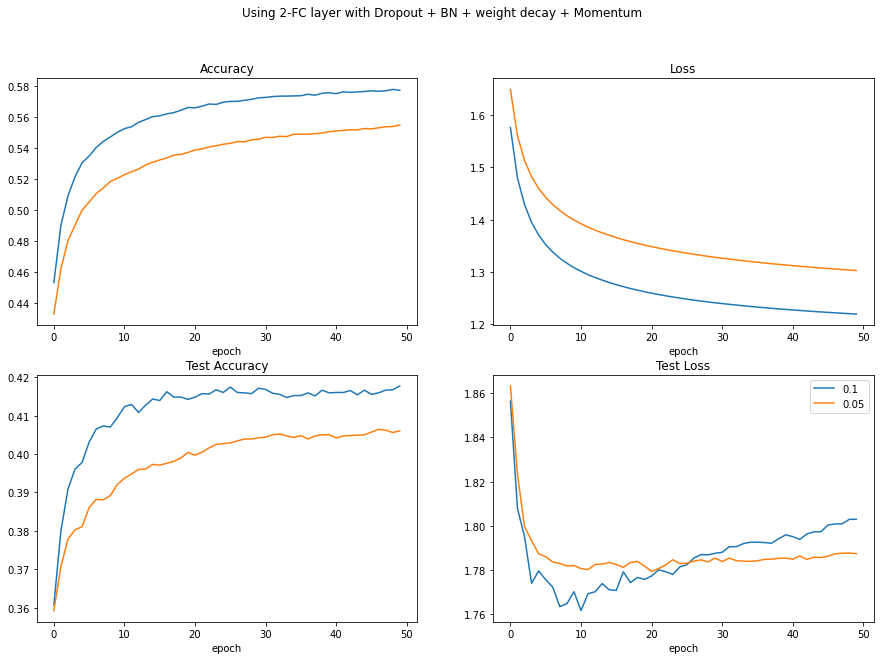

In [102]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.1, 0.05]
dropout_rate = 0
weight_decay = 0.0005

all_acc = []
all_loss = []
all_test_acc = []
all_test_loss = []

for i in learning_rate:
    experiment(epochs, batch_size, i, dropout_rate, all_acc, all_loss, all_test_acc, all_test_loss, y_train, y_test, weight_decay)


fig, axs = plt.subplots(2,2, figsize=(15,10))

for label, i in enumerate(all_acc):
    axs[0,0].plot(i, label=learning_rate[label])
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[0,1].plot(i, label=learning_rate[label])
    axs[0,1].set_title("Loss")
    axs[0,1].set_xlabel("epoch")

for label, i in enumerate(all_test_acc):
    axs[1,0].plot(i, label=learning_rate[label])
    axs[1,0].set_title("Test Accuracy")
    axs[1,0].set_xlabel("epoch")

for label, i in enumerate(all_test_loss):
    axs[1,1].plot(i, label=learning_rate[label])
    axs[1,1].set_title("Test Loss")
    axs[1,1].set_xlabel("epoch")

fig.suptitle('Using 2-FC layer with Dropout + BN + weight decay + Momentum')
plt.legend()
plt.show()


test_name = ['2f_dr_02_wg_00005_lr_01_bn_mom', '2f_dr_02_wg_00005_lr_005_bn_mom']

acc_train_df, loss_train_df, all_test_acc, all_test_loss = save_info_df(test_names=test_name, new=True)

Testing accuracy
--------------------------------------------------
acc:0.4120 |loss:1.7964
Done training
Testing accuracy
--------------------------------------------------
acc:0.4109 |loss:1.7899
Done training


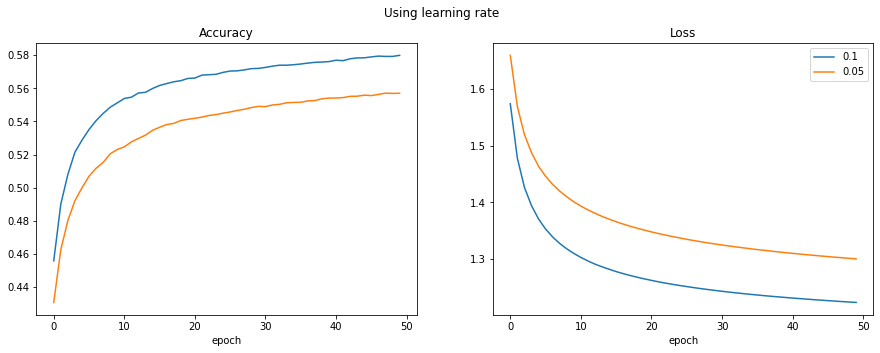

In [32]:
# #Set some of the paramaters for the training process
# epochs = 50
# batch_size = 128
# learning_rate = [0.1, 0.05]
# dropout_rate = 0
# weight_decay = 0.0005

# all_acc = []
# all_loss = []
# test_acc = []
# test_loss = []

# for i in learning_rate:
#     experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)

# fig, axs = plt.subplots(1,2, figsize=(15,5))

# for label, i in enumerate(all_acc):
#     axs[0].plot(i, label=learning_rate[label])

# axs[0].set_title("Accuracy")
# axs[0].set_xlabel("epoch")

# for label, i in enumerate(all_loss):
#     axs[1].plot(i, label=learning_rate[label])
# axs[1].set_title("Loss")
# axs[1].set_xlabel("epoch")


# fig.suptitle('Using learning rate')
# plt.legend()
# plt.show()


# # Concat the results
# test_name = ['2f_dr_02_wg_00005_lr_01_bn_mom', '2f_dr_02_wg_00005_lr_005_bn_mom']

# acc_train_df, loss_train_df, acc_test_series, loss_test_series = \
#     save_info_df(acc_train_df, loss_train_df, acc_test_series, loss_test_series, test_name, new=False)

In [104]:
# acc_train_df.to_csv("acc_train_df_b.csv", index=None)
# loss_train_df.to_csv("loss_train_df_b.csv", index=None)
# all_test_acc.to_csv("all_test_acc.csv")
# all_test_loss.to_csv("all_test_loss.csv")

(50, 2)